# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [31]:
# from __future__ import division
# declaramos las librerías
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#establecemos una semilla para que nos de los mismos numeros aletaorios
np.random.seed(100)

#### Dataset que se va a utilizar para el entrenamiento

In [32]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min=0 #mínimo valor
valor_max=256 #máximo valor 

valores_color=3 # RGB, tiene 3 valores
num_colores=100 #creamos un dataset con 100 colores
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores)) # los valores
datos=datos.T #hacemos la transpuesta

## SOM Setup
#### Variables definidas por el alumno

In [33]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 30 #30*30 =900, tendremos 900 neuronas
periodo = 15000 # las veces que se repite
learning_rate =  0.4 # cuanto se desplaza la neurona
normalizar_datos = True #normalizamos los datos


#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [34]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_color
num_datos = num_colores

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = datos/ (valor_max-1) # pasamos los valores de 0-255 a 0-1
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random([lado_mapa,lado_mapa,num_entradas])# lo ponemos directamente 30,30,3

#### Funciones para entrenar/clasificar

In [35]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
#calculamos la neurana que mas cerca se encuentra sel color buscado
#hemos sustituido la variable w(nos dio el profesor), por una variable de tipo Booleano llamada Buscar_Error_Topologico,
#Esto lo hemos hecho por si queremos buscra "la segunda" bmu a la hora de calcula el error topológico.
def calcular_bmu(patron_entrada, m_pesos, Buscar_Error_Topologico):
    #declaramos las variables correspondientes
    Minimo2=0.0 
    bmu_idx=[0,0]
    bmu_idx2=[0,0]
    #recorremos todas las neurnas
    for x in range(m_pesos.shape[0]):
        for x2 in range(m_pesos.shape[1]):
            #calculamos la distancia entre la neruona actual, y los datos de entrada
            Dist =np.sqrt(np.sum((m_pesos[x][x2] - patron_entrada) ** 2))
            if (x==0 and x2==0) or Dist<Minimo: #si es la primera neurona se guarda la distancia o si la distanci de la neurona acutal es meno a la que estaba guardada
                #actualizamos el Minimo
                Minimo=Dist
                
                bmu=m_pesos[x][x2].copy() #guardamos en la variable bmu, los valores de la neurona correspondiente
                #ponemos el .copy(), ya que sino, lo crea como un punterro, por lo que al despues hacer operaciones en
                #la variable bmu (suma, resta...) se modificara tambien la matriz de pesos, para evitar esto
                #ponemos el .copy() de forma que copie ese array en una nueva variable.
                 
                #guardamos las coordenadas 2d de las neuronas
                bmu_idx[0]=x
                bmu_idx[1]=x2
            elif Minimo2==0.0 or Dist<Minimo2: #esto lo hacemos para el error topológico
                Minimo2=Dist
                bmu_idx2[0]=x #se guarda la antigua neurona que era mas cercana, acabara siendo la 2 neurona 
                bmu_idx2[1]=x2 # mas cerca a la patron de entrada, esto lo acemos para el error topologico
               
    if Buscar_Error_Topologico: #si es para el error topológico, enviamos las dos BMU, mas cercanos a la entrada.
        return bmu_idx2,bmu_idx 
    return bmu,bmu_idx

In [36]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
#caunto varia el leraning rate
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    learning_rate=lr_inicial*(1-(i/ n_iteraciones)) #formula
    return learning_rate

In [37]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
#caunto varia el vecinadario
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    lvecindario=1+vecindario_inicial*(1-(i/ n_iteraciones)) #formula
    return lvecindario

In [38]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
#la amortiguación
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2)) #formula

#### Funciones para dibujar la salida de la red

In [39]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

#### Histograma 3D (Para representar el Mapa de Activacion)

In [40]:
# aqui pintaremos el histeriograma 3D
def histograma3D(datos):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #Creamos como una malla X-Y, se puede pensar como el suelo
    x_data, y_data = np.meshgrid( np.arange(datos.shape[1]), np.arange(datos.shape[0]) )

    '''
    Se necesitasn arrays planos tridimensionales (eso es lo que espera ax.bar3d), por eso hacemos el .flatten()
    x_data=cordenadas eje x
    y_data=cordenadas eje y
    z_data=cordenadas eje z
    '''
    
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = datos.flatten()
    
    colors = plt.cm.jet(z_data/float(datos.max())) # se crea una  matrix Lado*lado ,4 ; el 4 es porque esta en formato rgba
    #ejemplo si el hay 900 neuronas(30*30) , se crea una matriz de [900,4] y depedniedno del valor que tenga el mapa
    # de activacion se le dara un color u otro (en formato rgba): ej: para todos los valors =0, sera el azul, para todos los de 
    # valor 1, sera el verde y así...
    
    ax.bar3d( x_data,y_data,np.zeros(len(z_data)),0.7, 0.7, z_data, color=colors) 
    # Los dos valores numericos, representan el grosor de la barra, el primero respecto al eje x y el otro respecto al z
  
    ax.set_xlabel('Neuronas Eje X') #nombre eje X
    ax.set_ylabel('Neuronas Eje Y') #nombre eje Y
    ax.set_zlabel('Nº de veces activada') #nombre eje Z
    plt.show()


## SOM Entrenamiento

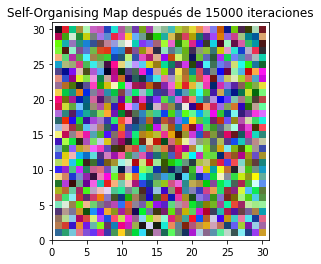

Iteración: 100
Iteración: 200
Iteración: 300
Iteración: 400
Iteración: 500
Iteración: 600
Iteración: 700
Iteración: 800
Iteración: 900
Iteración: 1000
Iteración: 1100
Iteración: 1200
Iteración: 1300
Iteración: 1400
Iteración: 1500
Iteración: 1600
Iteración: 1700
Iteración: 1800
Iteración: 1900
Iteración: 2000
Iteración: 2100
Iteración: 2200
Iteración: 2300
Iteración: 2400
Iteración: 2500
Iteración: 2600
Iteración: 2700
Iteración: 2800
Iteración: 2900
Iteración: 3000
Iteración: 3100
Iteración: 3200
Iteración: 3300
Iteración: 3400
Iteración: 3500
Iteración: 3600
Iteración: 3700
Iteración: 3800
Iteración: 3900
Iteración: 4000
Iteración: 4100
Iteración: 4200
Iteración: 4300
Iteración: 4400
Iteración: 4500
Iteración: 4600
Iteración: 4700
Iteración: 4800
Iteración: 4900
Iteración: 5000
Iteración: 5100
Iteración: 5200
Iteración: 5300
Iteración: 5400
Iteración: 5500
Iteración: 5600
Iteración: 5700
Iteración: 5800
Iteración: 5900
Iteración: 6000
Iteración: 6100
Iteración: 6200
Iteración: 6300
I

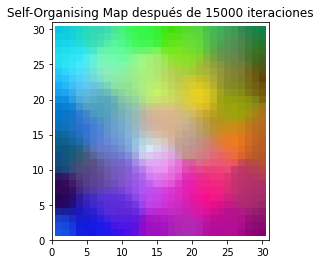

In [41]:
# Entrena la red con el dataset de entrenamiento
pintar_mapa(matriz_pesos) #pintamos los pesos iniciales
for iteracion in range(periodo): # recorremos le bucle 
    aleatorio=np.random.randint(num_datos) #cogemos un valor aleatorio entre 0 y el num_datos(100)
    
    ValoresEscogidos=datos[aleatorio] # cogemos un valor aleatorio del muestreo
    #Ponemos el False, indicando que no es para el error topológico, es decir que no queremos que nos devuelma las dos bmu
    #mas cercanas
 
    bmu,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,False) #sacamos el bmu y su posicion en 2d

    learning_rate_actual=variacion_learning_rate(learning_rate,iteracion,periodo) # calculamos el learning_rate_actual, el cual dependera de la iteracion
    matriz_pesos[bmu_idx[0]][bmu_idx[1]]+=learning_rate_actual*(ValoresEscogidos-bmu) #actualizamos la matriz de pesos de la BMU
    
    vecindario_actual=variacion_vecindario(vecindario,iteracion,periodo)# calculamos el vecindario_actual, el cual dependera de la iteracion
    
    #en este bucle veremos que neuronas forman parte del vecindario y actualizamos los pesos
    for x in range(matriz_pesos.shape[0]):
        for x2 in range(matriz_pesos.shape[1]):
            Coordenadas_Neurona=np.array([x, x2]) #guardamos las coordenadas 2d de la neurona
            distancia =np.sqrt(np.sum((bmu_idx - Coordenadas_Neurona) ** 2)) #calculamos la distancia entra la BMU y la neurona actual
            if distancia<=vecindario_actual: #si la distancia es meno al vecindario actual, significa que esta en el vecindario
                amortiguacion=decay(distancia,vecindario_actual) #calculamos la amortiguacion, para la neurona que esta dentro del vecindario
                matriz_pesos[x][x2]+= amortiguacion*learning_rate_actual*(ValoresEscogidos-matriz_pesos[x][x2])#actualizamos los pesos de la respectiva neurona
              
    
    if (iteracion+1)%100==0:# imprimimos cada 100 iteraciones
        print("Iteración: " + str(iteracion+1))
pintar_mapa(matriz_pesos) #pintamos como queda la matriz de pesos

## SOM Clasificación

In [42]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
#lo metemos dentro de una función, para que posteirormente en las pruebas, solo tengamos que llamar a esta funcion nuevamente
def clasificacion(datos,num_datos):
    Mapa_Clasificacion =np.zeros(matriz_pesos.shape) #guarda en cada neurona el último patrón clasificado.
    Mapa_Activacion =np.zeros((lado_mapa,lado_mapa)) #guarda el número de patrones reconocido por cada neurona
    Mapa_Distancias =np.zeros((lado_mapa,lado_mapa)) #guarda la distancia media de todos los patrones de la clase con su vector de pesos




    #dclaramos variables
    Distancia_Media=0.0
    Error_Topologico=0.0
    capas=0
    for iteracion in range(num_datos): #recorremos los datos de muestreo
        ValoresEscogidos=datos[iteracion] 
        bmu_idx2,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,True) #sacamos el bmu(es decir la neurona mas cercana a los datos de entrada)
        # y tambien sacamos el bmu2, esto lo hacemos para posteriormente calcular el erro topologico
        
        #imprimimos los datos de entrada y la nuerona que se ha activado
        print("Patron de Busqueda: " +str(ValoresEscogidos))
        print("Cordenadas de la BMU:" + str(bmu_idx)+"\n")
        
        
        #########################################
        #distancia media (Error de Cuantificación)
        #########################################
        distancia =np.sqrt(np.sum((matriz_pesos[bmu_idx[0]][bmu_idx[1]] - ValoresEscogidos) ** 2))#distancía euclidea
        Distancia_Media+=abs(distancia)

        #########################################
        #Error topológico
        #########################################    
        Segunda_BMU=np.array([bmu_idx2[0], bmu_idx2[1]]) # lo tranfromamos en un numpy array, para poder restar
        Distancia_Neuronas_Adyacentes= np.sqrt(np.sum((bmu_idx - Segunda_BMU) ** 2))
        if Distancia_Neuronas_Adyacentes>1.5:#las que esta encima y a los lados su distancia es 1, las que estan en diagonal
            Error_Topologico+=1   #su distancia es de 1.41, por eso ponemos > 1.5 para que nos coga todas menos esas


        ###############MAPAS############
        Mapa_Clasificacion[bmu_idx[0]][bmu_idx[1]]=ValoresEscogidos
        if Mapa_Activacion[bmu_idx[0]][bmu_idx[1]] >0: #si ya hay un valor en este neurona hacemos la media, entre el valor antiguo y nuevo
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] = (Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] + distancia) /2 #hacemos la media entre la distancia anterior y la nueva
        else:#si nunca se habia activado esta neurona...
            capas+=1 
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]]=distancia #guardamos la distancia

        Mapa_Activacion[bmu_idx[0]][bmu_idx[1]]+=1 #indicamos que ha esta neurona ha sido reconocida por el patron

    #calculamos la distancia media y el error topológico
    Distancia_Media/=num_datos
    Error_Topologico/=num_datos
    #imprimimos todos los datos
    print("Error de Cuantificación: "+ str(Distancia_Media))
    print("Error Topológico: "+ str(Error_Topologico))
    print("Capas: "+ str(capas))
    print("\nMapa de Clasificación: ")
    pintar_mapa(Mapa_Clasificacion)
    print("Mapa de Activación: ")
    histograma3D(Mapa_Activacion)
    print("\n\nMapa de Distancias:\n\n"+ str(Mapa_Distancias))

Patron de Busqueda: [0.03137255 0.51372549 0.28627451]
Cordenadas de la BMU:[29, 29]

Patron de Busqueda: [0.09411765 0.83137255 0.90980392]
Cordenadas de la BMU:[1, 27]

Patron de Busqueda: [0.2627451  0.81176471 0.71372549]
Cordenadas de la BMU:[6, 29]

Patron de Busqueda: [0.40392157 0.54117647 0.8627451 ]
Cordenadas de la BMU:[7, 13]

Patron de Busqueda: [0.34117647 0.84313725 0.25882353]
Cordenadas de la BMU:[20, 29]

Patron de Busqueda: [0.30980392 0.96470588 0.56470588]
Cordenadas de la BMU:[9, 27]

Patron de Busqueda: [0.69019608 0.9372549  0.52156863]
Cordenadas de la BMU:[12, 21]

Patron de Busqueda: [0.54117647 0.7372549  0.70196078]
Cordenadas de la BMU:[10, 18]

Patron de Busqueda: [0.36862745 0.51372549 0.35294118]
Cordenadas de la BMU:[25, 26]

Patron de Busqueda: [0.70588235 0.41176471 0.13333333]
Cordenadas de la BMU:[29, 15]

Patron de Busqueda: [0.38431373 0.69019608 0.76470588]
Cordenadas de la BMU:[6, 20]

Patron de Busqueda: [0.20784314 0.70588235 0.36862745]
Cord

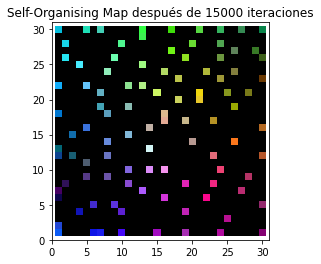

Mapa de Activación: 


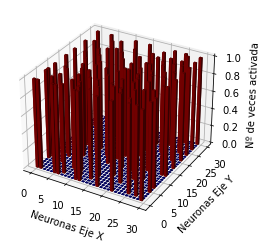



Mapa de Distancias:

[[0.05405413 0.04543199 0.         0.         0.         0.08208967
  0.078393   0.         0.         0.         0.         0.0589822
  0.06753242 0.         0.         0.         0.         0.01085468
  0.         0.         0.         0.02255064 0.         0.
  0.         0.         0.         0.         0.         0.03071073]
 [0.         0.         0.         0.         0.         0.
  0.         0.02829496 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.01021742 0.         0.00675114 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.03604643
  0.         0.         0.02948166 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.    

In [43]:
#hacemos la calsificación
clasificacion(datos,num_datos)

## SOM Prueba

Patron de Busqueda: [1. 1. 1.]
Cordenadas de la BMU:[13, 12]

Patron de Busqueda: [1. 0. 0.]
Cordenadas de la BMU:[26, 11]

Patron de Busqueda: [0. 1. 0.]
Cordenadas de la BMU:[15, 29]

Patron de Busqueda: [0. 0. 1.]
Cordenadas de la BMU:[5, 0]

Patron de Busqueda: [1. 1. 0.]
Cordenadas de la BMU:[20, 20]

Patron de Busqueda: [1. 0. 1.]
Cordenadas de la BMU:[16, 5]

Patron de Busqueda: [0. 1. 1.]
Cordenadas de la BMU:[1, 25]

Patron de Busqueda: [0. 0. 0.]
Cordenadas de la BMU:[0, 5]

Error de Cuantificación: 0.27068917359735506
Error Topológico: 0.0
Capas: 8

Mapa de Clasificación: 


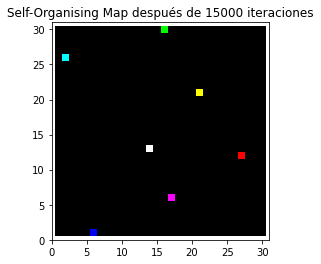

Mapa de Activación: 


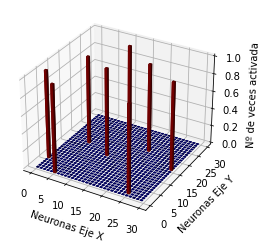



Mapa de Distancias:

[[0.         0.         0.         0.         0.         0.35714313
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.19694149 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.     

In [44]:
# Clasifica nuevos patrones
Dataset_prueba=np.array([[255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0]])
Num_Datos_prueba=Dataset_prueba.shape[0] #el nuemro de datos

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    Dataset_prueba = Dataset_prueba/ (valor_max-1) # pasamos los valores de 0-255 a 0-1
#clasificamos los datos de prueba  
clasificacion(Dataset_prueba,Num_Datos_prueba)